# Discrete and Continuous Control with A2C

Reinforcement learning (RL) is the study of agents taking actions in an environment in order to increase their "reward". This takes place in a perception-action-learning loop, whereby the agent receives a state/observation at every timestep, uses its policy to choose an action conditional on this observation, and then receives another observation and a scalar reward as the environment transitions to the next timestep. Through multiple interactions with the environment, the goal of the agent is to improve its policy so that it can maximise its expected cumulative reward.

![RL Loop](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/action-perception.png)

Unlike the usual supervised or unsupervised learning settings, the agent is responsible for the data it receives, and so it is far from "independent and identically distributed". Furthermore, there is a particularly difficult credit assignment problem - the agent has to work out which of its actions result in rewards, where the rewards caused by specific actions may appear a long time in the future. Nevertheless, RL provides a formal framework for studying this problem.

Here we'll look at the advantage actor-critic (A2C) algorithm, which combines an explicit policy (the actor) with value function estimation (the critic); the value function captures the expected cumulative reward from a given state and given a certain policy, or more informally how good a state is.

We'll look at learning to solve two classic control problems - cartpole and pendulum - using A2C. In contrast to the field of optimal control, we're not assuming that we have access to a (dynamics/forward) model of the environment. RL also includes the concept of model-based methods, which attempt to learn and use such models from data, but that won't be covered here.

## Environments

Firstly we'll instantiate the two environments and see how a random policy performs. This'll give us an idea of the problem to solve, as well as how a naive baseline would perform on it.

Just to note - we'll look at renders of the environment, but the observations for the agents will be a few symbolic inputs, such as the angle of the pole in the cartpole environment. However, the ability to learn policies "end-to-end", i.e., directly from pixels, is one of the major success of deep reinforcement learning.

In [1]:
#import time
import gym
from matplotlib import pyplot as plt
#import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from IPython.display import clear_output, display
%matplotlib inline

'Average reward: 33.00'

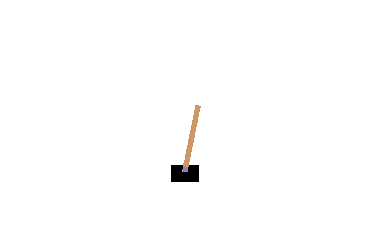

In [9]:
plt.axis('off')

env = gym.make('CartPole-v0')
obs = env.reset()
rollouts = 3
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

for _ in range(rollouts):
    env.reset()
    done = False
    while not done:
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

display('Average reward: %.2f' % (total_reward / rollouts))

'Average reward: -1525.91'

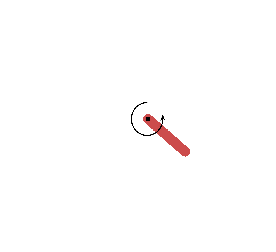

In [10]:
plt.axis('off')

env = gym.make('Pendulum-v0')
obs = env.reset()
rollouts = 3
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

for _ in range(rollouts):
    env.reset()
    done = False
    while not done:
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

display('Average reward: %.2f' % (total_reward / rollouts))

## Model

We'll construct a small fully-connected network with one hidden layer for both environments. For discrete control in cartpole (left or right) we'll use a categorical policy, and for continuous control in pendulum (torque) we'll use a Gaussian policy. For the latter we can actually sample using the reparameterisation trick.

In [13]:
class A2C(nn.Module):
    def __init__(self, obs_size, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(obs_size, 32)
        if env == 'cartpole':
            self.fc2 = nn.Linear(32, 1 + 2)
        elif env == 'pendulum':
            self.fc2 = nn.Linear(32, 1 + 1)
            self.pi_std_dev = nn.Parameter(torch.zeros(1, 1))

    def forward(self, obs):
        x = self.fc2(torch.tanh(self.fc1(obs)))
        V, pi = x[:, 0], x[:, 1:]
        if self.env == 'cartpole':
            pi = F.softmax(pi, dim=1)
            action = pi.multinomial(1).squeeze(1)
        elif self.env == 'pendulum':
            pi = (pi, F.softplus(self.pi_std_dev))
            action = pi[0] + pi[1] * torch.randn_like(pi[0])
        return action, pi, V

## Training

A2C

In [19]:
env = gym.make('CartPole-v0')
agent = A2C(4, 'cartpole')
optimiser = optim.RMSprop(agent.parameters(), lr=1e-3)
rollouts = 32
total_reward = 0


def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


for _ in range(rollouts):
    obs, done = obs_to_tensor(env.reset()), False
    while not done:
        action, pi, V = agent(obs)
        obs, reward, done, _ = env.step(action.item())
        obs = obs_to_tensor(obs)
        total_reward += reward

display('Average reward: %.2f' % (total_reward / rollouts))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


'Average reward: 28.94'

In [26]:
env = gym.make('Pendulum-v0')
agent = A2C(3, 'pendulum')
optimiser = optim.RMSprop(agent.parameters(), lr=1e-3)
rollouts = 32
total_reward = 0


def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


for _ in range(rollouts):
    obs, done = obs_to_tensor(env.reset()), False
    while not done:
        action, pi, V = agent(obs)
        obs, reward, done, _ = env.step([action.item()])
        obs = obs_to_tensor(obs)
        total_reward += reward

display('Average reward: %.2f' % (total_reward / rollouts))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


'Average reward: -1480.49'